In [51]:
import json
import os
import csv
import math
import ast 
import pandas as pd
import seaborn as sns

path = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/data/events'
event_files = []
all_files = os.listdir(path)

for i in range(0, len(all_files), 10):
    nom = os.path.join(path, all_files[i])
    if os.path.isfile(nom):
        event_files.append(nom)

# Archivo de salida CSV
output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'

# Centro de la portería y campos de interés
goal_center = [120, 40]
fields = [
    'event_id', 'period', 'minute',  
    'team', 'player', 'location', 'shot_distance',
    'shot_angle', 'body_part', 'play_pattern', 'freeze_frame', 
    'technique', 'statsbomb_xg', 'type', 'aerial_won', 'open_goal'
]

with open(output_csv, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fields)
    writer.writeheader()

    for file_path in event_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            events = json.load(f)
            
            match_id = os.path.basename(file_path).replace('.json', '')
            
            for event in events:
                if event.get('type', {}).get('name') == 'Shot':
                    location = event.get('location')
                    aerial_won=event.get('shot', {}).get('aerial_won')
                    open_goal= event.get('shot',{}).get('open_goal')
                    freeze_frame=event.get('shot', {}).get('freeze_frame')
                    if location:
                        # Calcular distancia euclidiana a la portería (hipotenusa)
                        shot_distance = math.sqrt((goal_center[0] - location[0]) ** 2 + (goal_center[1] - location[1]) ** 2)
                        
                        # Calcular distancia horizontal (lado adyacente)
                        adj_side = abs(goal_center[0] - location[0])
                        
                        # Calcular ángulo del tiro usando el arcocoseno
                        if shot_distance != 0:
                            shot_angle = math.degrees(math.acos(adj_side / shot_distance))
                        else:
                            shot_angle = None
                    else:
                        shot_distance = None
                        shot_angle = None
                    if aerial_won:
                        aerial_won=1
                    else:
                        aerial_won=0
                    if open_goal:
                        open_goal=1
                    else:
                        open_goal=0 
                    if (freeze_frame is None)or (type(freeze_frame)==list and len(freeze_frame)==0):
                        freeze_frame=0
                    else:
                        freeze_frame=freeze_frame

                    shot_data = {
                        'event_id': event.get('id'),
                        'period': event.get('period'),
                        'minute': event.get('minute'),
                        'team': event.get('team', {}).get('name'),
                        'player': event.get('player', {}).get('name'),
                        'location': location,
                        'shot_distance': shot_distance,
                        'shot_angle': shot_angle,
                        'body_part':event.get('shot', {}).get('body_part', {}).get('name'),
                        'play_pattern': event.get('play_pattern', {}).get('name'),
                        'freeze_frame': freeze_frame,
                        'technique': event.get('shot', {}).get('technique', {}).get('name'),
                        'statsbomb_xg': event.get('shot', {}).get('statsbomb_xg'),
                        'type': event.get('shot', {}).get('type', {}).get('name'),
                        'aerial_won': aerial_won,
                        'open_goal': open_goal
                    }
                    
                    writer.writerow(shot_data)

print(f"Datos de remates extraídos y guardados en {output_csv}")

Datos de remates extraídos y guardados en C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv


Tot seguit convertim la característica freeze_frame a una llista de diccionaris perquè al recopilar-lo des dels arxius .json es transmet en forma de cadena.

In [52]:
import pandas as pd
import ast

output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'
df = pd.read_csv(output_csv)
df2 = pd.read_csv(output_csv)

def convert_freeze_frame(value):
    try:
        if value == "0":  
            return []
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

df['freeze_frame'] = df['freeze_frame'].apply(convert_freeze_frame)
df2['freeze_frame'] = df2['freeze_frame'].apply(convert_freeze_frame)

In [53]:
def calcular_distancia(punt1, punt2):
    return math.sqrt((punt2[0] - punt1[0]) ** 2 + (punt2[1] - punt1[1]) ** 2)


def calcular_angle(origen, punt1, punt2):
    if(origen!=None and punt1!=None and punt2!=None):
        vector1 = (origen[0]-punt1[0], origen[1]-punt1[1])
        vector2 = (origen[0]-punt2[0], origen[1]-punt2[1])
        producto_escalar = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        magnitud1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)
        magnitud2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)
        if magnitud1 == 0 or magnitud2 == 0:
            return None
        cos_angulo = producto_escalar / (magnitud1 * magnitud2)
        angulo = math.acos(max(min(cos_angulo, 1), -1))  
        return math.degrees(angulo)
    else:
        return 0

A continuació, ens hem adonat que la característica freeze_frame és molt carregosa, ja que conté diverses informacions sobre cadascun dels rivals en el moment del xut. Com que inclou molta informació irrellevant, per reduir la dimensionalitat del dataset hem ideat un coeficient que substitueix freeze_frame. Aquest coeficient considera la distància entre el punt de xut i cadascun dels jugadors rivals de manera regulada. Es calcula de forma exponencial, de manera que les distàncies grans tenen molt menys pes. A més, hem decidit incorporar-hi una constant arbitrària d0, que regula els valors de la funció. Aquesta constant es pot ajustar posteriorment, tractant-la com un hiperparàmetre del model.
La funció en qüestió que hem dissenyat per modelitzar la pressió és:
$\sum_{i=1}^{11} \frac{e^{-\frac{d_i}{d_0}}}{11}$

On:
-  $d_i$ és la distància del rival $i$ al rematador.
- $d_0$ és un paràmetre de referència utilitzat per regular la funció.

D'aquesta manera, en el cas hipotètic de que la pressió fos màxima (si el rematador pogués tenir els 11 jugadors a 0 metres de distància) el coeficient seria 1. En el cas contrari (si els jugadors rivals poguessin estar a una distància infinita del rematador) seria 0.


In [54]:
d0=100
def calcul_coeficient_Tubert_Mercader(d0):
    llista_coeficients = []
    for idx, row in df2.iterrows():  
        coeficient_Tubert_Mercader = 0
        punt_xutador = ast.literal_eval(row['location'])  
        freeze_frame = row['freeze_frame']
        
        for jugador in freeze_frame:  
            if not jugador.get('teammate', True):
                punt_rival = jugador['location']
                if (punt_rival[0]+2>punt_xutador[0] or calcular_distancia(punt_xutador,punt_rival)<2): 
                    dist = calcular_distancia(punt_xutador, punt_rival)
                    coeficient_Tubert_Mercader += math.exp(-dist/d0) 
        llista_coeficients.append(coeficient_Tubert_Mercader/11)
    
    df2['freeze_frame'] = llista_coeficients
    df2.rename(columns={'freeze_frame': 'coeficientTM'}, inplace=True)
    return [llista_coeficients]

calcul_coeficient_Tubert_Mercader(d0)
print(df2.head())


                               event_id  period  minute              team  \
0  becd7956-ce44-479e-8fc9-16a2d1f1f349       1       2         Barcelona   
1  9107d374-2942-4876-a14f-1b9f86901c15       1       5         Barcelona   
2  ddd194ca-08fb-43d0-87c2-33647f975f9f       1      15         Barcelona   
3  86596ddb-d824-4e5e-b18c-b4442e9ce7cf       1      16  Deportivo Alavés   
4  3ed2b107-be17-42d5-9d1b-25006a0e55cb       1      18         Barcelona   

                           player       location  shot_distance  shot_angle  \
0  Lionel Andrés Messi Cuccittini  [111.5, 52.9]      15.448625   56.618524   
1                Jordi Alba Ramos  [113.9, 26.4]      14.905368   65.842363   
2  Lionel Andrés Messi Cuccittini   [93.7, 34.7]      26.828716   11.393698   
3           Rubén Sobrino Pozuelo  [109.2, 39.1]      10.837435    4.763642   
4        Luis Alberto Suárez Díaz  [107.8, 24.7]      19.568597   51.431645   

    body_part   play_pattern  coeficientTM    technique  stats

In [55]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for jugador in aux:
        if jugador['position']['name']=='Goalkeeper':
            posicio_porter= jugador['location']
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        df.at[i,'distancia jugador'+" "+str(idx)]=distancia
        df.at[i,'angle jugador'+" "+str(idx)]=angle_rematador_rival_porter
        
 

In [56]:
#TO DO:INSPECCIÓ NANS ANGLES:

In [57]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                   0
period                     0
minute                     0
team                       0
player                     0
location                   0
shot_distance              0
shot_angle                 0
body_part                  0
play_pattern               0
freeze_frame               0
technique                  0
statsbomb_xg               0
type                       0
aerial_won                 0
open_goal                  0
distancia jugador 0      117
angle jugador 0         2769
distancia jugador 1      132
angle jugador 1          809
distancia jugador 2      147
angle jugador 2          615
distancia jugador 3      238
angle jugador 3          656
distancia jugador 4      435
angle jugador 4          887
distancia jugador 5      809
angle jugador 5         1356
distancia jugador 6     1445
angle jugador 6         2121
distancia jugador 7     2494
angle jugador 7         3243
distancia jugador 8     4008
angle jugador 8         4793
distancia juga

Com podem veure, tot i que el nombre de nans entre "distancia jugador i" i "angle jugador i" hauria de coincidir, als angles tenen bastants mes Nans en comparació amb les distàncies, especialment en els primers registres. Anem a veure què pot estar passant prenent com mostra l'angle del jugador 0 (característica on es dona més el fenòmen i on hi ha una clara evidència de que no és casualitat)

In [58]:
llista=[j for j in range(len(df)) if pd.isnull(df['angle jugador 0'][j])]
inspeccio=[]
for i in llista:
    if (len(df['freeze_frame'][i])>0):
        inspeccio.append(df['freeze_frame'][i][0]['position']['name'])
        
unic = set(inspeccio)  
position_counts = {position:inspeccio.count(position) for position in unic}
ordenat=dict(sorted(position_counts.items(), key=lambda item: item[1], reverse=True))
for i,j in ordenat.items():
    print(i,":",j)
    

Goalkeeper : 1667
Center Forward : 127
Right Wing : 102
Left Wing : 82
Left Back : 71
Left Center Midfield : 67
Right Back : 63
Right Center Midfield : 56
Left Midfield : 47
Center Attacking Midfield : 46
Right Defensive Midfield : 46
Left Defensive Midfield : 45
Right Center Forward : 44
Left Center Forward : 40
Right Midfield : 35
Right Center Back : 28
Left Center Back : 26
Left Wing Back : 19
Center Defensive Midfield : 14
Right Wing Back : 14
Right Attacking Midfield : 5
Left Attacking Midfield : 4
Center Back : 4


Com podem comprovar la majoria dels valor Nans de l'angle del jugador 0 són en porters ja que la funció calcular_angle agafa com a origen la posició del porter, aleshores, com hem establert en la funció, l'angle que formarà el porter amb el rematador agafant la posició del guardameta com a origen serà None.
A continuació omplenarem aquests valors per l'angle que es forma entre el porter i el rematador respecte el centre de la porteria. En cas que el porter estigui exactament al centre de la porteria assignarem l'angle calculat al principi "shot_angle" que equival a l'angle format entre el rematador i el centre de la porteria (on està ara el porter).

In [59]:
#ASSIGNAR NANS

In [60]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_porter_porteria = calcular_angle(goal_center, posicio_rival, posicio_rematador)
        if jugador['position']['name']=='Goalkeeper'and posicio_rival!=goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= angle_rematador_porter_porteria
        elif jugador['position']['name']=='Goalkeeper'and posicio_rival==goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= df['shot_angle'][i]
df.to_csv(output_csv, index=False)

In [61]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                   0
period                     0
minute                     0
team                       0
player                     0
location                   0
shot_distance              0
shot_angle                 0
body_part                  0
play_pattern               0
freeze_frame               0
technique                  0
statsbomb_xg               0
type                       0
aerial_won                 0
open_goal                  0
distancia jugador 0      117
angle jugador 0          117
distancia jugador 1      132
angle jugador 1          132
distancia jugador 2      147
angle jugador 2          147
distancia jugador 3      238
angle jugador 3          238
distancia jugador 4      435
angle jugador 4          435
distancia jugador 5      809
angle jugador 5          809
distancia jugador 6     1445
angle jugador 6         1445
distancia jugador 7     2494
angle jugador 7         2494
distancia jugador 8     4008
angle jugador 8         4008
distancia juga

In [62]:
#Explicar per què assignem 0 als jugadors per darrera la pilota a una certa distància i per què assignem 0 als Nans.

In [63]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        if(posicio_rival[0]<posicio_rematador[0] and distancia>=2):
            df.at[i,'distancia jugador'+" "+str(idx)]=0
            df.at[i,'angle jugador'+" "+str(idx)]=0

df.dropna(axis=1, thresh=len(df) * 0.5, inplace=True)  
df.fillna(0, inplace=True)

In [64]:
#TO DO: EXPLICAR PER QUÈ INVERTIM L'EIX Y (CARACTERÍSTIQUES DEL DATASET)

In [65]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_field(ax):
    # Dimensiones del campo
    field_length = 120
    field_width = 80

    # Dibujar el contorno del campo
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([60, 60], [0, field_width], color="black")

    # Dibujar las áreas de penalti
    ax.plot([0, 18, 18, 0], [18, 18, 62, 62], color="black")  # Área izquierda
    ax.plot([120, 102, 102, 120], [18, 18, 62, 62], color="black")  # Área derecha

    # Dibujar las áreas pequeñas
    ax.plot([0, 6, 6, 0], [30, 30, 50, 50], color="black")  # Área pequeña izquierda
    ax.plot([120, 114, 114, 120], [30, 30, 50, 50], color="black")  # Área pequeña derecha

    # Dibujar los círculos centrales y los puntos de penalti
    center_circle = patches.Circle((60, 40), 10, color="black", fill=False)  # Círculo central
    ax.add_patch(center_circle)
    ax.plot(60, 40, 'o', color="black")  # Centro del campo
    ax.plot(12, 40, 'o', color="black")  # Punto penal izquierdo
    ax.plot(108, 40, 'o', color="black")  # Punto penal derecho

    # Dibujar los arcos de las áreas de penalti
    left_arc = patches.Arc((18, 40), 10, 15, theta1=-90, theta2=90, color="black")
    right_arc = patches.Arc((102, 40), 10,15, theta1=90, theta2=270, color="black")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Dibujar los arcos de las porterías
    ax.plot([0, 0], [36, 44], color="black")  # Portería izquierda
    ax.plot([120, 120], [36, 44], color="black")  # Portería derecha

    # Configurar los límites del gráfico
    ax.set_xlim(-5, field_length + 5)
    ax.set_ylim(-5, field_width + 5)
    ax.set_aspect("equal")

    # Invertir el eje Y para que Y=0 esté en la parte superior
    ax.invert_yaxis()



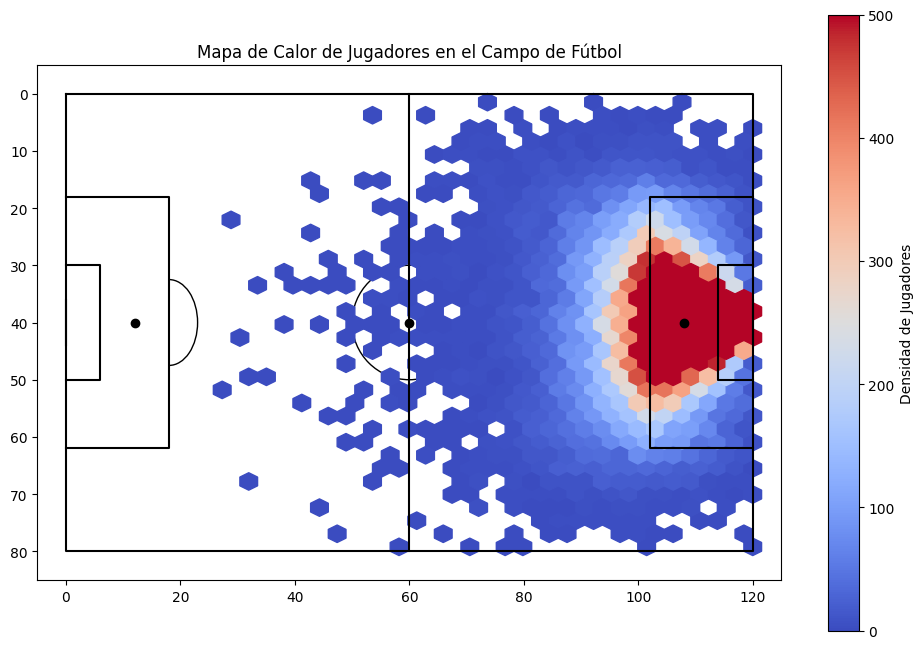

In [66]:
# Coordenadas de los jugadores
x = []
y = []
for i in range(len(df)):
    element = df['freeze_frame'][i]
    for jugador in [j for j in element if j['teammate'] == False]:
        if jugador['location'][0] is not None and jugador['location'][1] is not None:
            x.append(jugador['location'][0])
            y.append(jugador['location'][1])


fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1, vmin=0, vmax=500)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densidad de Jugadores')


ax.set_title("Mapa de Calor de Jugadores en el Campo de Fútbol")
plt.show()


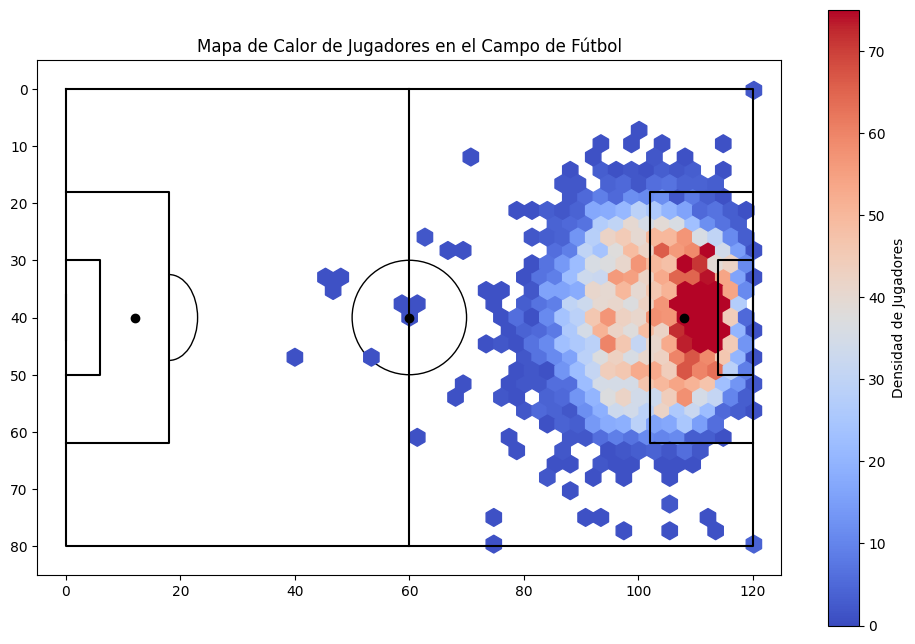

In [67]:
x=[]
y=[]
for i in range(len(df)):
    posicio_rematador=ast.literal_eval(df['location'][i])
    x.append(posicio_rematador[0])
    y.append(posicio_rematador[1])
fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1,vmin=0, vmax=75)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densidad de Jugadores')


ax.set_title("Mapa de Calor de Jugadores en el Campo de Fútbol")
plt.show()

In [68]:
df.drop('freeze_frame', axis=1, inplace=True)


In [69]:
print(df.describe())
print(df.head(10))
print(df.size)
#TO DO: ABANS DE MODIFICAR FREEZE_FRAME HEM DE FER EL PREPOCESSING AMB ELS NANS.
#TO DO: EXPLICAR PER QUÈ TRANSFORMEM LES DADES DE FREEZE_FRAME AMB ast.literal_eval
#for i in range(len(df)):
#    df.iloc[i,df.columns.get_loc('freeze_frame')]=ast.literal_eval(df.iloc[i,df.columns.get_loc('freeze_frame')])

           period       minute  shot_distance   shot_angle  statsbomb_xg  \
count  8680.00000  8680.000000    8680.000000  8680.000000   8680.000000   
mean      1.56394    49.113710      19.225478    27.959656      0.105038   
std       0.54061    27.048183       8.640976    18.919669      0.147216   
min       1.00000     0.000000       0.943398     0.000000      0.000180   
25%       1.00000    26.000000      12.053215    12.011478      0.027338   
50%       2.00000    49.000000      18.637194    25.965376      0.054084   
75%       2.00000    72.000000      25.656383    41.423666      0.108938   
max       5.00000   125.000000      80.202805    90.000000      0.973276   

        aerial_won    open_goal  distancia jugador 0  angle jugador 0  \
count  8680.000000  8680.000000          8680.000000      8680.000000   
mean      0.081797     0.010023             9.328276        17.632102   
std       0.274071     0.099618             9.745127        26.665403   
min       0.000000     

In [70]:
#NaNs columna 
missing_values = df.isnull().sum()
print(missing_values)
missing_percentages = (missing_values / len(df)) * 100

print("Percentatge de valors NaN per columna:\n", missing_percentages[missing_percentages > 0])

missing_values = missing_values[missing_values > 0]



event_id               0
period                 0
minute                 0
team                   0
player                 0
location               0
shot_distance          0
shot_angle             0
body_part              0
play_pattern           0
technique              0
statsbomb_xg           0
type                   0
aerial_won             0
open_goal              0
distancia jugador 0    0
angle jugador 0        0
distancia jugador 1    0
angle jugador 1        0
distancia jugador 2    0
angle jugador 2        0
distancia jugador 3    0
angle jugador 3        0
distancia jugador 4    0
angle jugador 4        0
distancia jugador 5    0
angle jugador 5        0
distancia jugador 6    0
angle jugador 6        0
distancia jugador 7    0
angle jugador 7        0
distancia jugador 8    0
angle jugador 8        0
dtype: int64
Percentatge de valors NaN per columna:
 Series([], dtype: float64)


In [71]:
#Com podem veure, el fet que alguns remats tinguéssin NaNs a freeze_frame es deu a que es tracta de penals (on el realitzador no té cap jugador que el pugui condicionar.)

In [72]:
"""import numpy as np
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = [k for k in df.keys() if k not in numeric_features]"""

'import numpy as np\nnumeric_features = df.select_dtypes(np.number).keys()\nnon_numeric = [k for k in df.keys() if k not in numeric_features]'

In [73]:
"""
from sklearn.preprocessing import LabelEncoder, StandardScaler
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)
print (df.dtypes)
df.head()
"""
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
for i in [df,df2]:
    numeric_features = i.select_dtypes(include=np.number).keys()
    non_numeric = [col for col in i.columns if col not in numeric_features]
    label_encoders = {}
    for col in non_numeric:
        le = LabelEncoder()
        i[col] = le.fit_transform(i[col])
        label_encoders[col] = le
    print(i.dtypes)


event_id                 int32
period                   int64
minute                   int64
team                     int32
player                   int32
location                 int32
shot_distance          float64
shot_angle             float64
body_part                int32
play_pattern             int32
technique                int32
statsbomb_xg           float64
type                     int32
aerial_won               int64
open_goal                int64
distancia jugador 0    float64
angle jugador 0        float64
distancia jugador 1    float64
angle jugador 1        float64
distancia jugador 2    float64
angle jugador 2        float64
distancia jugador 3    float64
angle jugador 3        float64
distancia jugador 4    float64
angle jugador 4        float64
distancia jugador 5    float64
angle jugador 5        float64
distancia jugador 6    float64
angle jugador 6        float64
distancia jugador 7    float64
angle jugador 7        float64
distancia jugador 8    float64
angle ju

C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


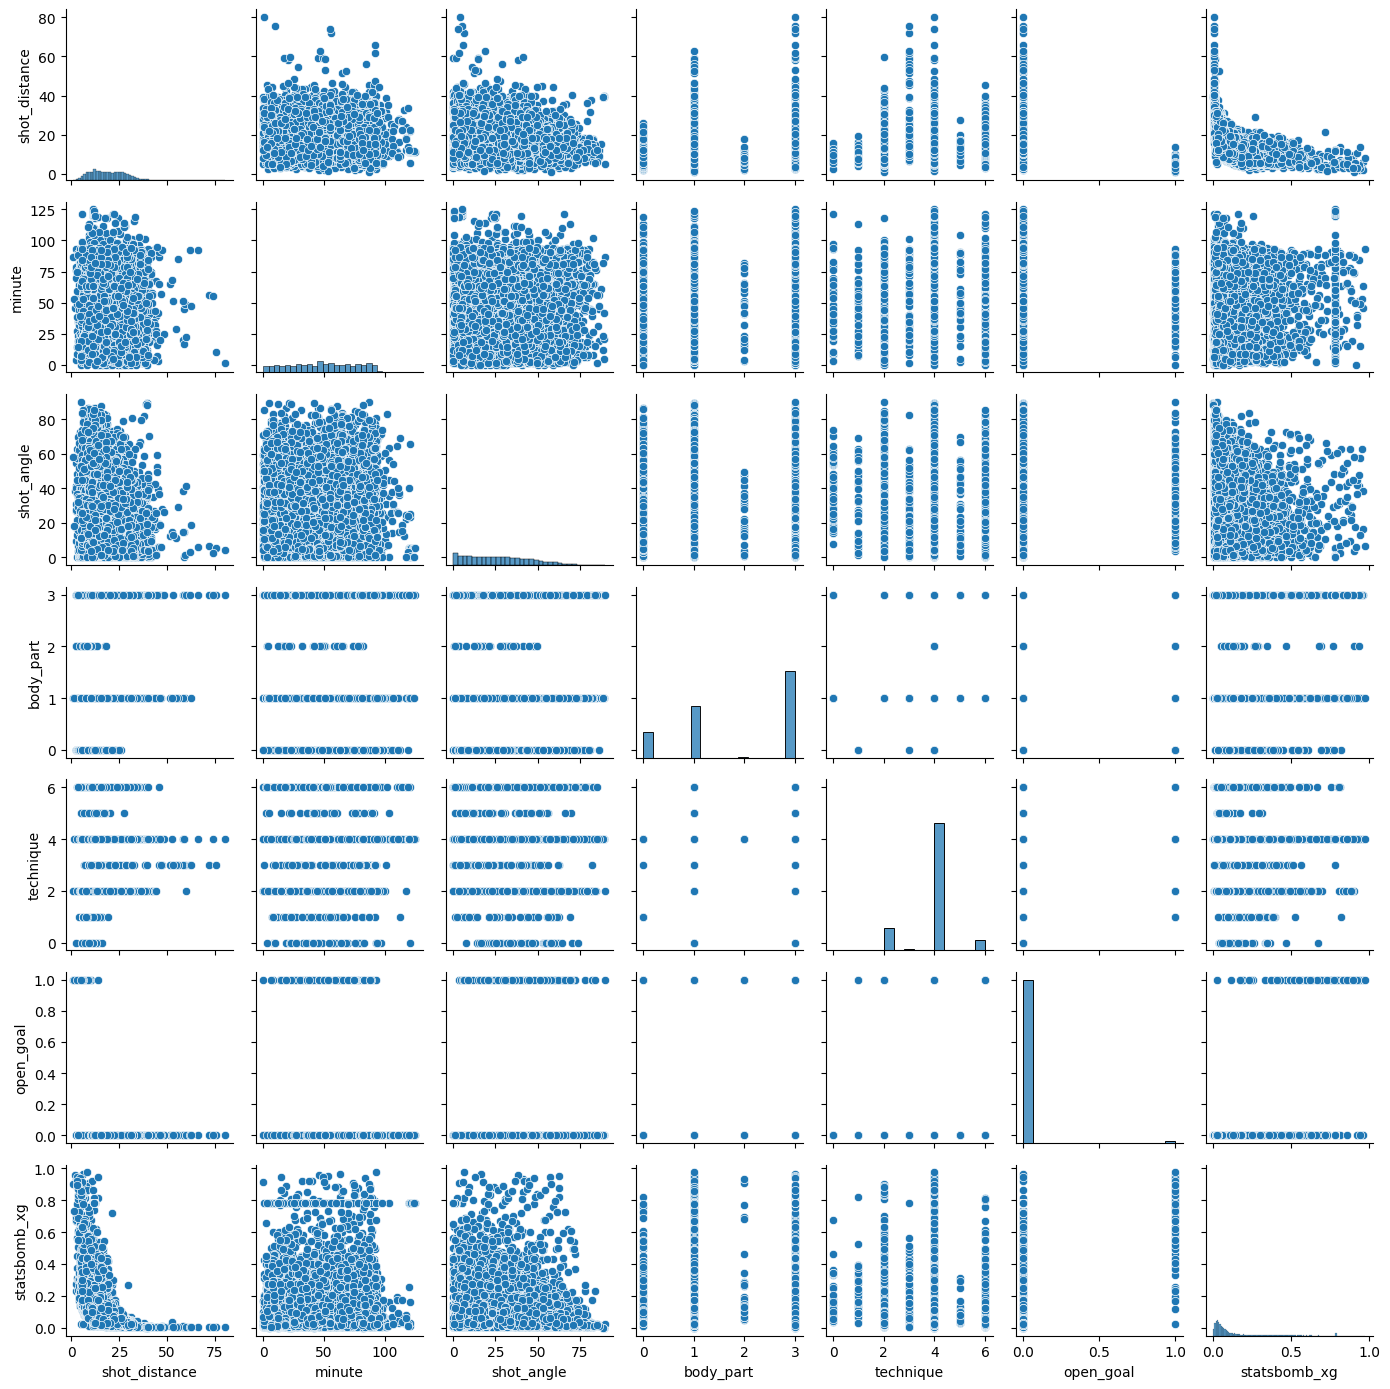

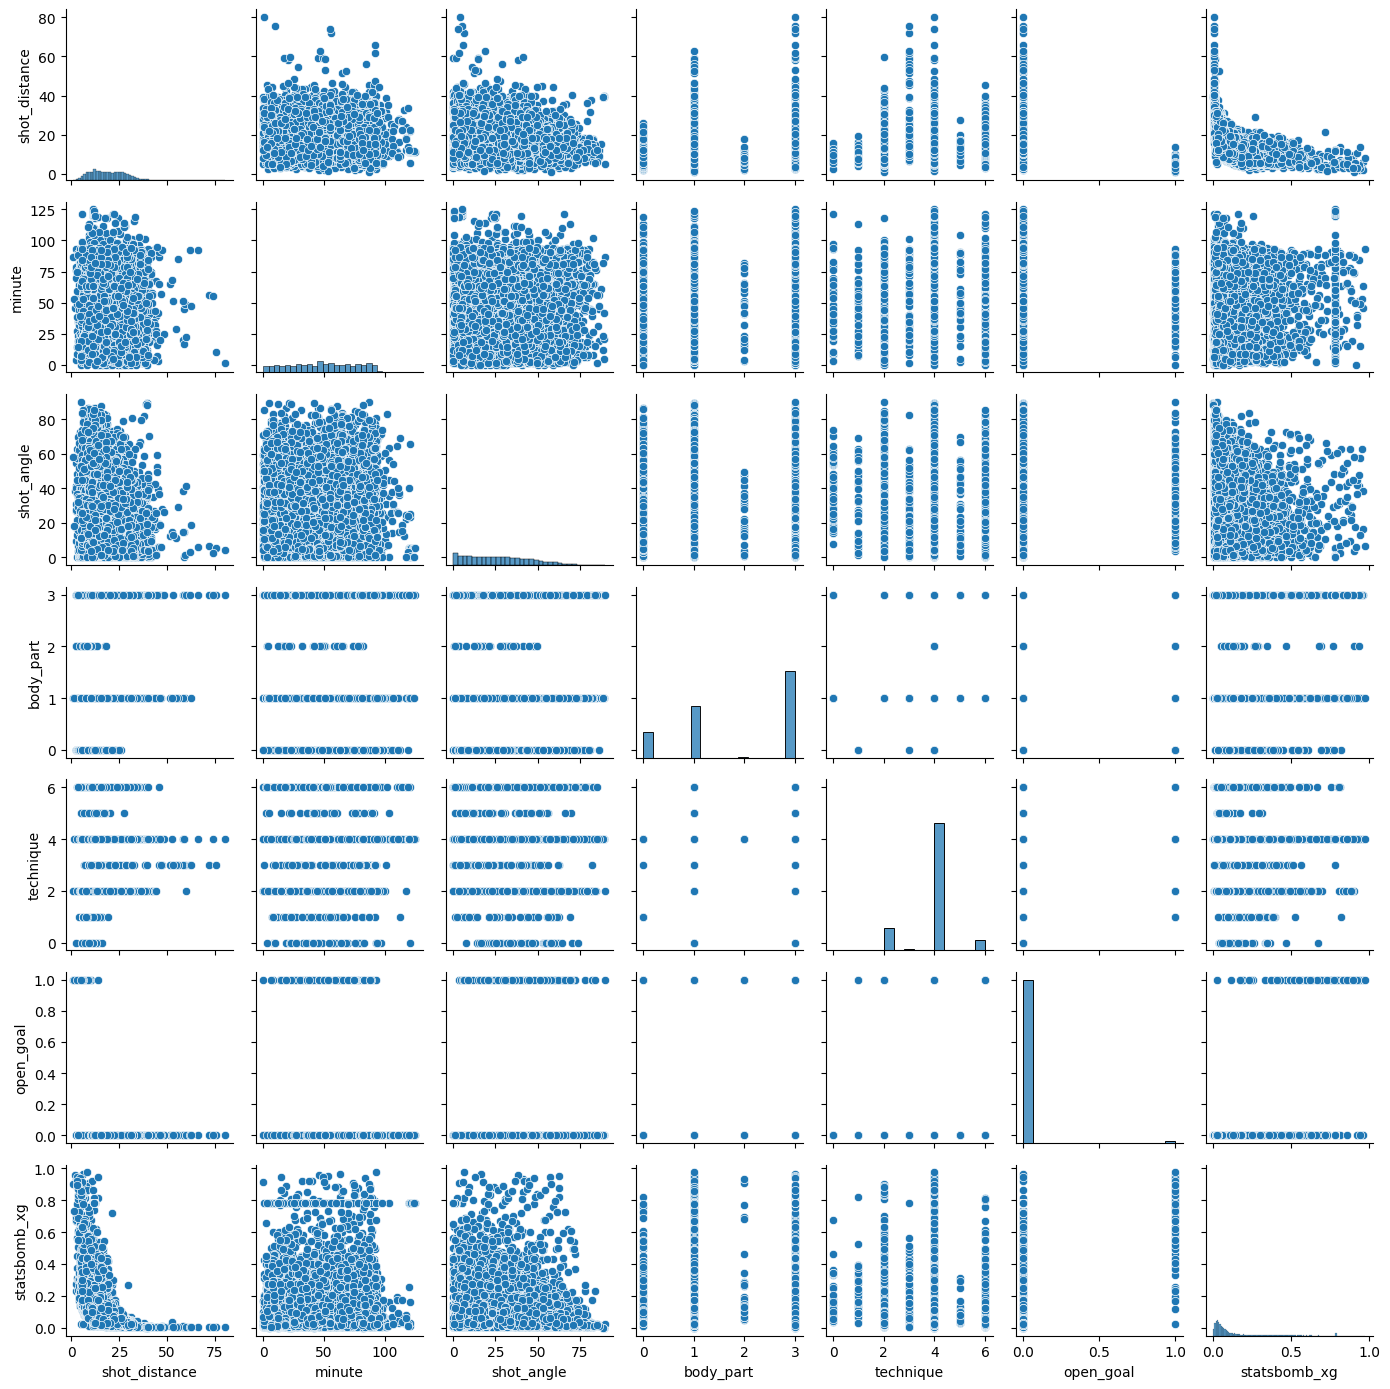

In [74]:
for i in [df,df2]:
    cols=['shot_distance','minute',
        'shot_angle', 'body_part',
        'technique', 'open_goal','statsbomb_xg',]
    sns.pairplot(i[cols], size=2)
    plt.tight_layout()
plt.show()


Com podem veure la distància del xut manté una relació exponencial amb els expected goals. Concretament, la relació és de statsbomb_xg=e^(-shot_distance). Per tant provarem de fer una transformació del tipus: f(x)=-log(x) per treballar amb unes dades que s'adaptin millor a una possible regressió.

C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


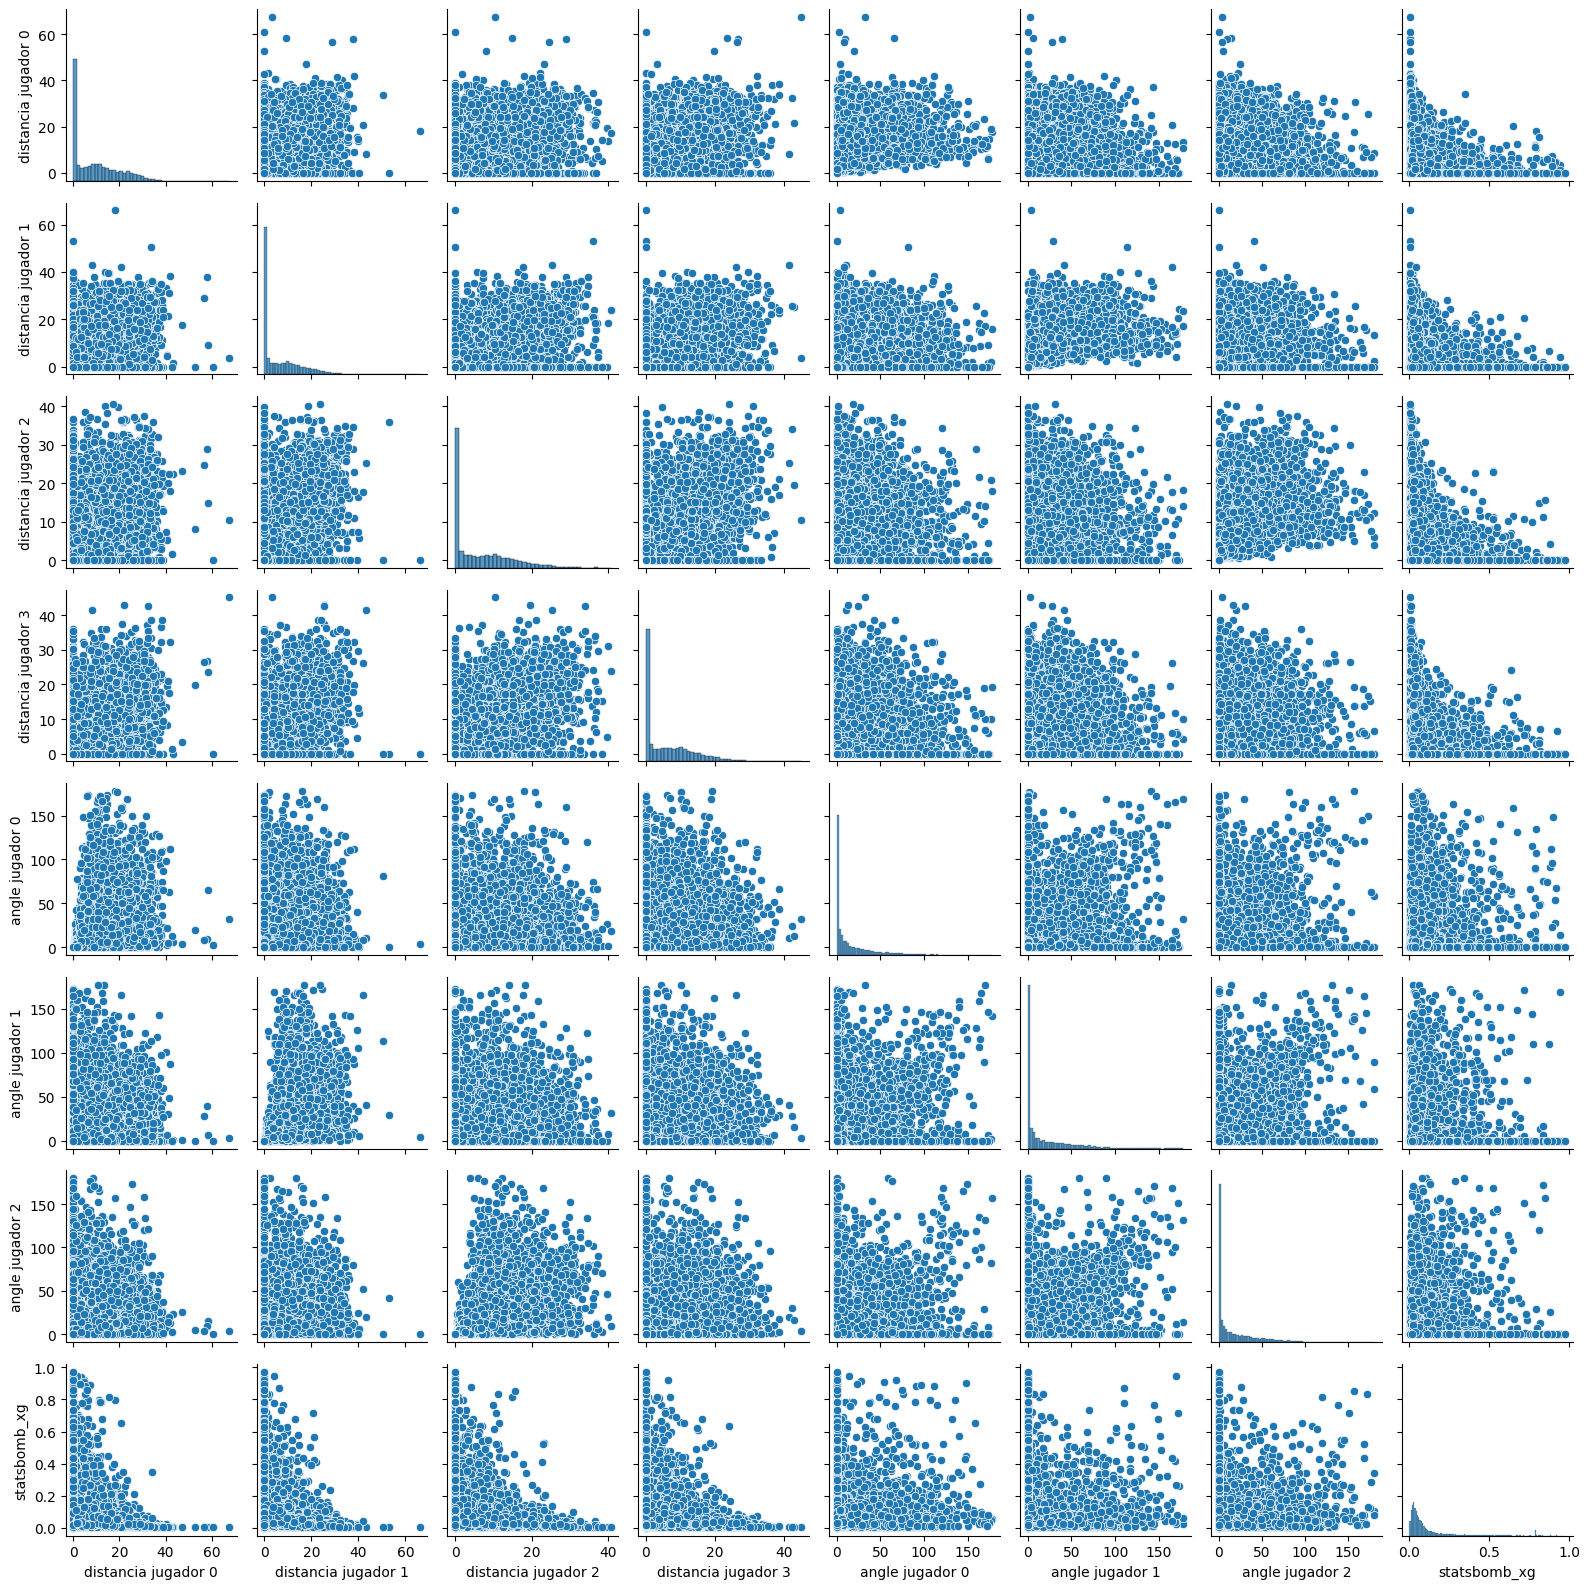

In [75]:
cols=['distancia jugador 0','distancia jugador 1',
    'distancia jugador 2', 'distancia jugador 3',
    'angle jugador 0', 'angle jugador 1','angle jugador 2','statsbomb_xg']
sns.pairplot(df[cols], size=2)
plt.tight_layout()
plt.show()

In [76]:
df['shot_distance']=np.log(df['shot_distance'])
print(df['shot_distance'].head(10))
df['distancia jugador 0']=np.log(df['distancia jugador 0'])
df['distancia jugador 1']=np.log(df['distancia jugador 1'])
df['distancia jugador 2']=np.log(df['distancia jugador 2'])
df['distancia jugador 3']=np.log(df['distancia jugador 3'])
df['distancia jugador 4']=np.log(df['distancia jugador 4'])
df['distancia jugador 5']=np.log(df['distancia jugador 5'])
df['distancia jugador 6']=np.log(df['distancia jugador 6'])
df['distancia jugador 7']=np.log(df['distancia jugador 7'])
df['distancia jugador 8']=np.log(df['distancia jugador 8'])

0    2.737520
1    2.701721
2    3.289473
3    2.383006
4    2.973926
5    2.815247
6    2.039954
7    3.283343
8    2.036731
9    3.001029
Name: shot_distance, dtype: float64


C:\Users\eloim\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [77]:
df2['shot_distance']=np.log(df2['shot_distance'])

Correlacions de totes les variables amb expected_goals:
event_id               0.011226
period                 0.072268
minute                 0.050020
team                  -0.014349
player                 0.022589
location              -0.140917
shot_distance         -0.584508
shot_angle            -0.112385
body_part             -0.028149
play_pattern           0.070306
technique             -0.010240
statsbomb_xg           1.000000
type                   0.246465
aerial_won            -0.014412
open_goal              0.385100
distancia jugador 0   -0.333799
angle jugador 0       -0.053362
distancia jugador 1   -0.304090
angle jugador 1       -0.090975
distancia jugador 2   -0.292606
angle jugador 2       -0.084837
distancia jugador 3   -0.274884
angle jugador 3       -0.091197
distancia jugador 4   -0.304731
angle jugador 4       -0.100142
distancia jugador 5   -0.281054
angle jugador 5       -0.112430
distancia jugador 6   -0.299886
angle jugador 6       -0.132538
distancia jugado

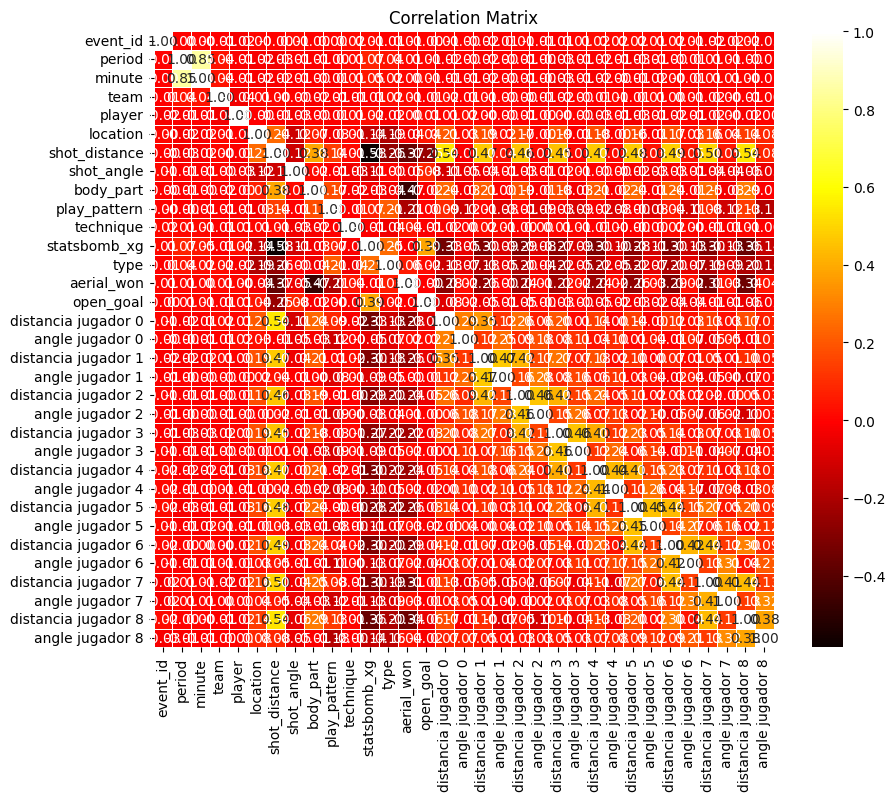

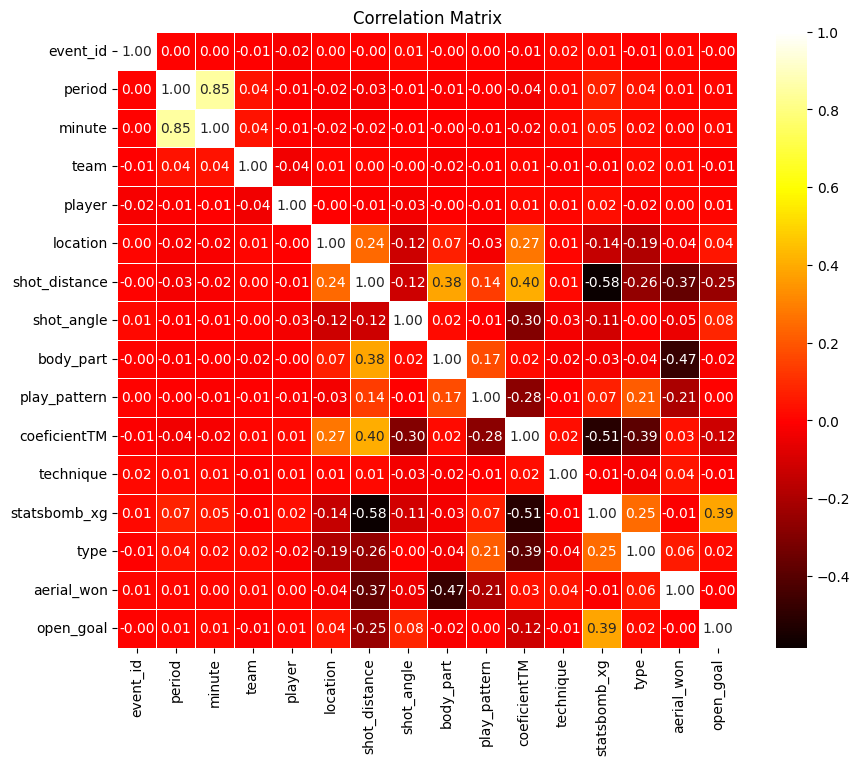

In [78]:
for i in [df,df2]:
    correlation_matrix = i.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='hot', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    correlation_with_survived = correlation_matrix['statsbomb_xg']
    print("Correlacions de totes les variables amb expected_goals:")
    print(correlation_with_survived)



In [79]:
#TO DO: EXPLICAR QUÈ ENS CARREGUEM A CONTINUACIÓ

In [85]:
df.drop('player', axis=1, inplace=True)
df.drop('event_id',axis=1, inplace=True)
df.drop('team', axis=1, inplace=True)

KeyError: "['player'] not found in axis"

In [81]:
#TO DO: EXPLICAR NORMALITZACIÓ

In [89]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reemplazar valores infinitos por 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Normalizar las columnas seleccionadas
scaler = StandardScaler()

columns_to_normalize = ['minute', 'location', 'shot_distance', 'shot_angle',
                        'distancia jugador 0', 'angle jugador 0','distancia jugador 1', 'angle jugador 1',
                        'distancia jugador 2', 'angle jugador 2','distancia jugador 3', 'angle jugador 3',
                        'distancia jugador 4', 'angle jugador 4','distancia jugador 5', 'angle jugador 5',
                        'distancia jugador 6', 'angle jugador 6','distancia jugador 7', 'angle jugador 7',
                        'distancia jugador 8', 'angle jugador 8']

# Asegurarse de que no haya valores infinitos ni NaN antes de normalizar
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Imprimir los resultados de las primeras filas y estadísticas descriptivas
print(df[columns_to_normalize].head())
print(df.describe())

     minute  location  shot_distance  shot_angle  distancia jugador 0  \
0 -1.741944 -0.148700      -0.203965    1.514853            -1.208168   
1 -1.631025  0.221968      -0.274555    2.002408            -1.208168   
2 -1.261293  1.090136       0.884416   -0.875645            -0.812842   
3 -1.224319 -0.508266      -0.903020   -1.226097            -1.208168   
4 -1.150373 -0.758510       0.262198    1.240685            -0.427635   

   angle jugador 0  distancia jugador 1  angle jugador 1  distancia jugador 2  \
0        -0.661273            -1.013692        -0.658091            -1.043955   
1        -0.661273            -1.013692        -0.658091            -1.043955   
2        -0.640785            -1.013692        -0.658091            -1.043955   
3        -0.661273             0.672755        -0.032894            -1.043955   
4        -0.568272             1.145525         1.839758             0.900987   

   angle jugador 2  ...  distancia jugador 4  angle jugador 4  \
0        

In [93]:
scaler = StandardScaler()
columns_to_normalize2 = ['minute', 'location', 'shot_distance', 'shot_angle', 'coeficientTM']
df2[columns_to_normalize2] = scaler.fit_transform(df2[columns_to_normalize2])
print(df2[['minute', 'location', 'shot_distance', 'shot_angle', 'coeficientTM']].head())

     minute  location  shot_distance  shot_angle  coeficientTM
0 -1.741944 -0.148700      -0.203965    1.514853     -1.534255
1 -1.631025  0.221968      -0.274555    2.002408     -1.559305
2 -1.261293  1.090136       0.884416   -0.875645      0.367744
3 -1.224319 -0.508266      -0.903020   -1.226097     -1.132261
4 -1.150373 -0.758510       0.262198    1.240685      0.544585


In [122]:
import statsmodels.api as sm
model=[]
results=[]
for idx, bd in enumerate([df,df2]):
    target_att = 'statsbomb_xg'
    attributes = [k for k in bd.keys() if k!= target_att]
    X = bd[attributes]
    y = bd[[target_att]]
    X = sm.add_constant(X)
    model.append(sm.OLS(y,X))
    results.append(model[idx].fit())
results[0].summary()
results[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           statsbomb_xg   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     934.9
Date:                Wed, 04 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:37:46   Log-Likelihood:                 8491.6
No. Observations:                8680   AIC:                        -1.695e+04
Df Residuals:                    8664   BIC:                        -1.684e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0649      0.010      6.494      0.000       0.045       0.085
event_id       6.656e-07    3.9e-07      1.705      0.088   -9.95e-08    1.43e-06
period            0.0189      0.003      5.562      0.000       0.012       0.026
minute           -0.0047      0.002     -2.533      0.011      -0.008      -0.001
team          -9.222e-06   1.54e-05     -0.599      0.549   -3.94e-05     2.1e-05
player         1.964e-06   1.46e-06      1.348      0.178   -8.93e-07    4.82e-06
location          0.0033      0.001      3.193      0.001       0.001       0.005
shot_distance    -0.0769      0.001    -58.370      0.000      -0.079      -0.074
shot_angle       -0.0463      0.001    -44.479      0.000      -0.048      -0.044
body_part         0.0141      0.001     14.711      0.000       0.012       0.016
play_pattern     -0.0006      0.000     -1.600      0.110      -0.001       0.000
coeficientTM     -0.0554      0.001    -43.429      0.000      -0.058      -0.053
technique         0.0008      0.001      0.779      0.436      -0.001       0.003
type             -0.0062      0.002     -2.673      0.008      -0.011      -0.002
aerial_won       -0.0841      0.004    -19.730      0.000      -0.092      -0.076
open_goal         0.3499      0.010     33.965      0.000       0.330       0.370
==============================================================================
Omnibus:                     3816.799   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30364.209
Skew:                           1.926   Prob(JB):                         0.00
Kurtosis:                      11.314   Cond. No.                     5.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
###ENTRENAMENT MODEL#####
#Separem X i Y
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split

for i in [df,df2]:

    target_att = 'statsbomb_xg'
    attributes = [k for k in i.keys() if k!= target_att]
    lr = LinearRegression(fit_intercept = True)

    X = i[attributes]
    y = i[[target_att]]

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

    lr.fit(X_train,y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    r2_train = r2_score(y_train,y_pred_train)
    r2_test = r2_score(y_test,y_pred_test)

    print (r2_train,r2_test)

    mse_train_linear = mean_squared_error(y_train, y_pred_train)
    mse_test_linear = mean_squared_error(y_test, y_pred_test)

    print(f"MSE Train (Linear Regression): {mse_train_linear}")
    print(f"MSE Test (Linear Regression): {mse_test_linear}")

0.5703593827547053 0.5481247326533693
MSE Train (Linear Regression): 0.009389900173851447
MSE Test (Linear Regression): 0.00959650711219713
0.6252469222070518 0.5998542580727069
MSE Train (Linear Regression): 0.00819031965106392
MSE Test (Linear Regression): 0.008497923510770562


Com podem veure, tot i ser uns resultats decents per ser el primer model que apliquem al conjunt de dades, podem veure que possiblement una regressió lineal no captura bé les relacions més complexes que podem tenir al nostre model. També podem veure que el valor del MSE és molt baix, tot i així no és tan significatiu com sembla perquè estem predint probabilitats i per tant valors entre 0 i 1, per tant és obvi que serà baix.

In [95]:
from sklearn.preprocessing import PolynomialFeatures

for i in [df,df2]:
    
    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

    poly = PolynomialFeatures(degree=2)  
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    lr = LinearRegression(fit_intercept=True)
    model=lr.fit(X_train_poly, y_train)

    y_pred_train = lr.predict(X_train_poly)
    y_pred_test = lr.predict(X_test_poly)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
    mse_train_linear = mean_squared_error(y_train, y_pred_train)
    mse_test_linear = mean_squared_error(y_test, y_pred_test)

    print(f"MSE Train: {mse_train_linear}")
    print(f"MSE Test: {mse_test_linear}")

R2 Train: 0.8574526956843649, R2 Test: 0.7738190217796361
MSE Train: 0.0031154060017822864
MSE Test: 0.004803421481508995
R2 Train: 0.8597801766797627, R2 Test: 0.802431535515088
MSE Train: 0.003064538338609639
MSE Test: 0.004195775497314262


Els resultats indiquen que el model de regressió polinòmica de grau 2 està funcionant bé. Els valors de R² són elevats tant en entrenament com en prova, mostrant que el model és capaç de capturar la major part de la variabilitat en les dades. A més, el MSE baix en ambdós conjunts suggereix que el model fa prediccions precises tant per les dades d'entrenament com per les de prova.

Aquestes mètriques indiquen que el model té una bona capacitat de predicció i generalització, i que la transformació polinòmica de grau 2 ha estat una bona elecció per ajustar la relació entre les característiques i la variable objectiu (probabilitat de gol).

Com podem veure és molt millor que la regressió lineal perquè té un millor r2 score i MSE, a més tot i que sembla que la diferència entre train i test és més gran no és prou significativa com per considerar l'existència d'overfitting.

In [96]:
print(max(abs(lr.coef_[0])),lr.intercept_)

for i in range(len(attributes)):
  print (attributes[i],lr.coef_[0][i])



2.819772188408467 [0.31278664]
event_id -4.224478001539038e-09
period 3.0552600974217625e-06
minute -0.049120258280836215
team 0.03271669407599962
player -0.0001324776826151318
location 1.0262962659923362e-05
shot_distance -0.005885795367476949
shot_angle -0.15869749325594681
body_part -0.030727182383306993
play_pattern 0.1305775645292124
coeficientTM 1.3209279287223639
technique -0.093899188560039
type 0.010244329717365094
aerial_won -2.819772188408467
open_goal 0.01831866188551757


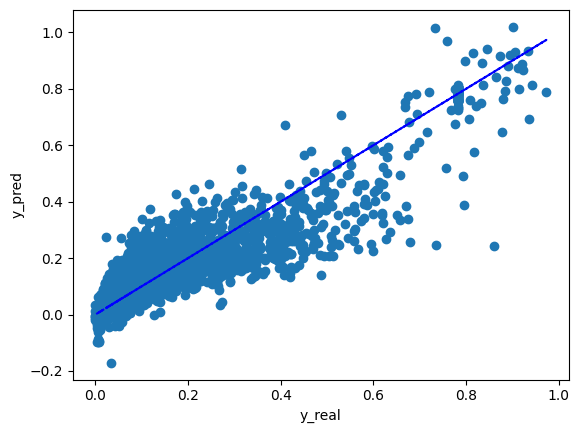

In [97]:
plt.scatter(y_train,y_pred_train)
plt.plot(y,y,'--',c = 'blue')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

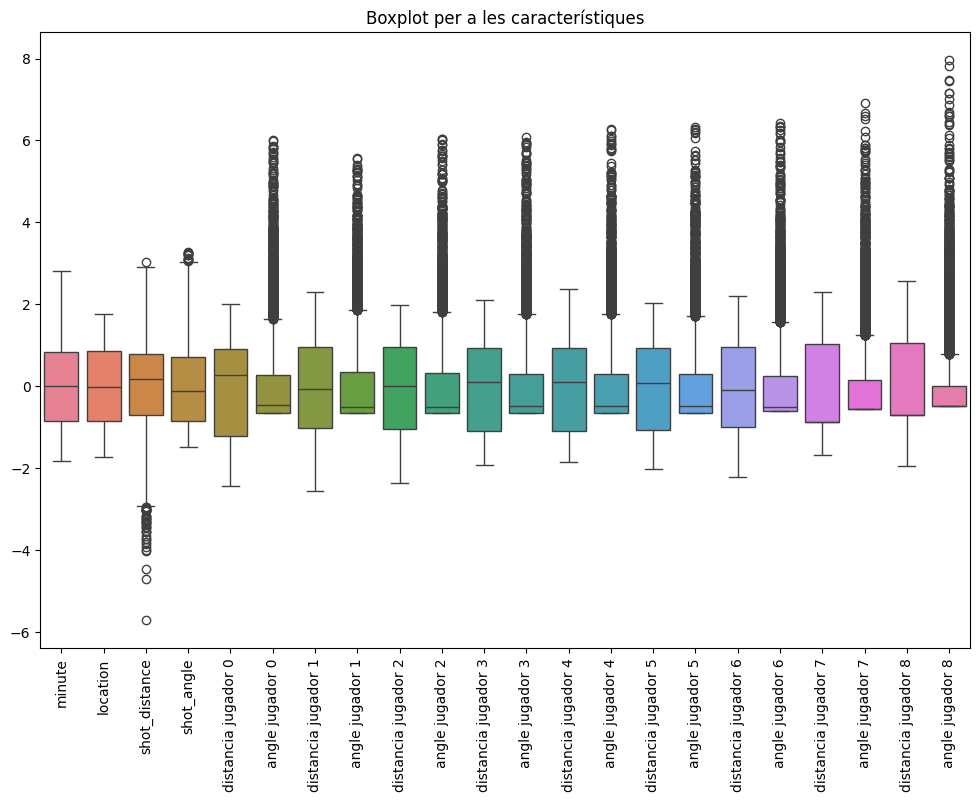

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un boxplot per cada característica
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[columns_to_normalize])
plt.title('Boxplot per a les característiques')
plt.xticks(rotation=90)
plt.show()


Com podem veure en aquest Boxplot tenim una quantitat considerable d'outliers als angles dels rivals. Els outliers es mostren com a punts situats fora de les "caixes" (els límits de la caixa són el quartil 1 i quartil 3, i les línies de la caixa mostren el rang interquartil).

Tot seguit aplicarem IQR (Rang interquartil): El mètode IQR detecta outliers com aquells punts que es troben fora del rang definit pels quartils 1 i 3 (Q1 - 1.5IQR, Q3 + 1.5IQR).

In [99]:
Q1 = df[columns_to_normalize].quantile(0.25)
Q3 = df[columns_to_normalize].quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers utilitzant IQR
outliers = ((df[columns_to_normalize] < (Q1 - 1.5 * IQR)) | (df[columns_to_normalize] > (Q3 + 1.5 * IQR)))
print(f'Número d\'outliers per columna:\n{outliers.sum()}')


Número d'outliers per columna:
minute                    0
location                  0
shot_distance            41
shot_angle               13
distancia jugador 0       0
angle jugador 0         676
distancia jugador 1       0
angle jugador 1         562
distancia jugador 2       0
angle jugador 2         564
distancia jugador 3       0
angle jugador 3         606
distancia jugador 4       0
angle jugador 4         583
distancia jugador 5       0
angle jugador 5         643
distancia jugador 6       0
angle jugador 6         709
distancia jugador 7       0
angle jugador 7         960
distancia jugador 8       0
angle jugador 8        1290
dtype: int64


In [ ]:
#TO DO: EXPLICAR RANSAC

In [102]:
from sklearn.linear_model import RANSACRegressor

for i in [df, df2]:


    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)


    ransac = RANSACRegressor(max_trials=100, min_samples=200, 
                             loss='squared_error', residual_threshold=0.2, random_state=42)
    ransac.fit(X_train_poly, y_train)

    y_pred_train = ransac.predict(X_train_poly)
    y_pred_test = ransac.predict(X_test_poly)


    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
    mse_train_ransac = mean_squared_error(y_train, y_pred_train)
    mse_test_ransac = mean_squared_error(y_test, y_pred_test)
    print(f"MSE Train (RANSAC): {mse_train_ransac}")
    print(f"MSE Test (RANSAC): {mse_test_ransac}")


R2 Train: 0.8532854787066051, R2 Test: 0.765049273521695
MSE Train (RANSAC): 0.003206481542253365
MSE Test (RANSAC): 0.004989665247457247
R2 Train: 0.8590095791421184, R2 Test: 0.8078990287010409
MSE Train (RANSAC): 0.0030813799351958513
MSE Test (RANSAC): 0.004079661956617559


In [111]:
from sklearn.linear_model import LogisticRegression

for i in [df, df2]:

    attributes = [k for k in i.keys() if k!= target_att]
    X = i[attributes]
    y = i[[target_att]]


    threshold = 0.50 
    y_binary = (i['statsbomb_xg'] > threshold).astype(int)  # Considera gol si P(Y=1) > 0.5

    X = i[attributes]  
    y = y_binary  

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Crear el modelo de regresión logística
    logreg = LogisticRegression(max_iter=10000)

    # Ajustar el modelo
    logreg.fit(X_train, y_train)

    # Obtener las probabilidades predichas (P(y=1 | x))
    y_prob_train = logreg.predict_proba(X_train)[:, 1]  
    y_prob_test = logreg.predict_proba(X_test)[:, 1]   

    r2_train = r2_score(y_train, y_prob_train)
    r2_test = r2_score(y_test, y_prob_test)

    print(f'R² Train: {r2_train}')
    print(f'R² Test: {r2_test}')


R² Train: 0.7070652820164667
R² Test: 0.630399059126132
R² Train: 0.7224602116628291
R² Test: 0.6405020009686562


In [107]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

poly = PolynomialFeatures(degree=2)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test) 


decision_tree = DecisionTreeRegressor(max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42)

decision_tree.fit(X_train_poly, y_train)

y_pred_train = decision_tree.predict(X_train_poly)
y_pred_test = decision_tree.predict(X_test_poly)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'R² Train: {r2_train}')
print(f'R² Test: {r2_test}')
print(f'MSE Train: {mse_train}')
print(f'MSE Test: {mse_test}')


R² Train: 0.738305896271725
R² Test: 0.6071821375045562
MSE Train: 0.008812278820470441
MSE Test: 0.012403845883476558


In [160]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

xg_boost = xgb.XGBRegressor(max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42)

xg_boost.fit(X_train, y_train)

y_pred_train = xg_boost.predict(X_train)
y_pred_test = xg_boost.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'R² Train: {r2_train}')
print(f'R² Test: {r2_test}')
print(f'MSE Train: {mse_train}')
print(f'MSE Test: {mse_test}')

C:\Users\eloim\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:40:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


R² Train: 0.9999879545023762
R² Test: 0.8045380480412363
MSE Train: 2.6325727990321364e-07
MSE Test: 0.004151039341344018


C:\Users\eloim\AppData\Local\Temp\ipykernel_12132\198045682.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lass.fit(X_train,y_train)
C:\Users\eloim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\eloim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e+01, tolerance: 1.328e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


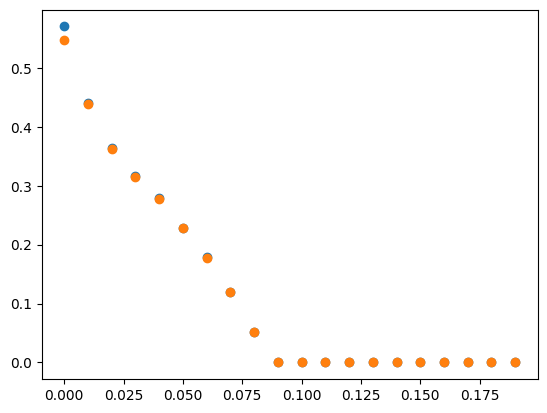

In [162]:
#Anem ara a fer un escombrat del hiperparametre de regularitzacio
alphas = np.arange (0,0.2,0.01)
r2_train_list = []
r2_test_list = []
for alpha in alphas:
  lass = Lasso(alpha = alpha)
  lass.fit(X_train,y_train)

  y_pred_train = lass.predict(X_train)
  y_pred_test = lass.predict(X_test)

  r2_train_list.append(r2_score(y_train,y_pred_train))
  r2_test_list.append(r2_score(y_test,y_pred_test))
    
plt.scatter(alphas,r2_train_list)
plt.scatter(alphas,r2_test_list)
plt.show()

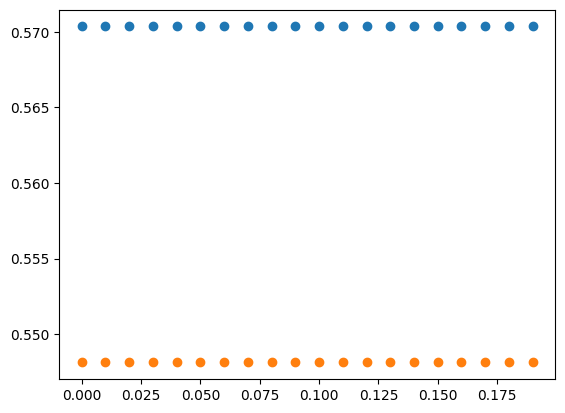

In [168]:
#Anem ara a fer un escombrat del hiperparametre de regularitzacio
alphas = np.arange (0,0.2,0.01)
r2_train_list1 = []
r2_test_list2 = []
for alpha in alphas:
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train,y_train)

  y_pred_train = ridge.predict(X_train)
  y_pred_test = ridge.predict(X_test)

  r2_train_list1.append(r2_score(y_train,y_pred_train))
  r2_test_list2.append(r2_score(y_test,y_pred_test))
    
plt.scatter(alphas,r2_train_list1)
plt.scatter(alphas,r2_test_list2)
plt.show()